In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

lidar_import = np.load('lidar_data.npz')
intensity = lidar_import['intensity']
dem = lidar_import['dem']
dsm = lidar_import['dsm']
shadow = lidar_import['shadow']

### Lidar Surface Processing ###

Several lidar derivatives have previously been generated and are loaded above. These include:

* Intensity Raster: grayscale image derived from the pixel-wise average magnitude of lidar intensity returned.
* Bare Earth DEM: surface model of topography derived from lidar points previously classified as terrain
* First Return DSM: surface model of the highest lidar point per pixel
* Estimated Shadow Raster: locations of expected shadows at time of image collection; built from lidar DSM

Our focus is processing hyperspectral imagery at the ground level that has been obscured by shadows. As such, we want to use the lidar data to identify regions which are likely homogenous surfaces. We can do this through combining the intensity information with the surface information. To start, we will generate a normalized-DSM and use it to mask data that is not at the ground level. 

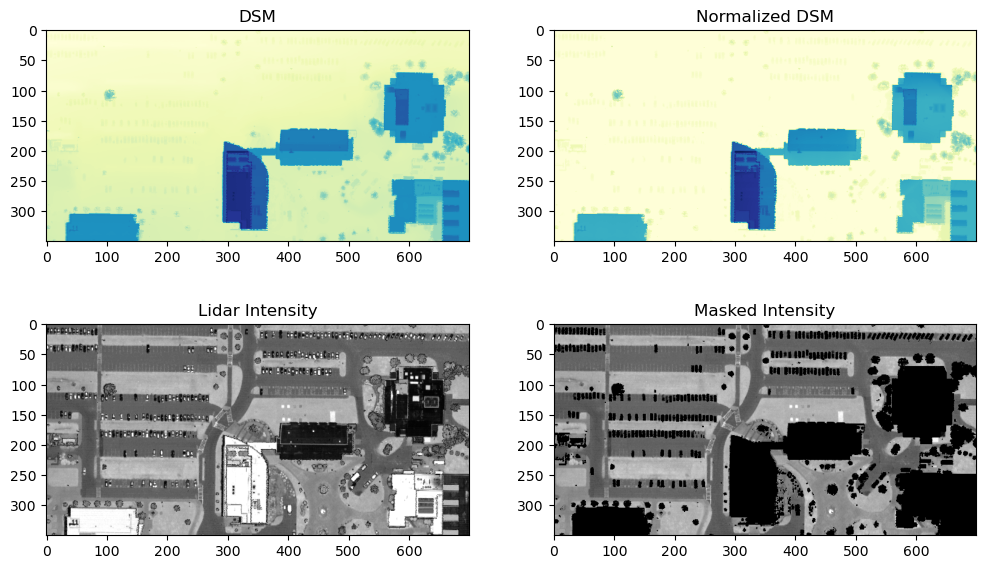

In [27]:
ndsm = dsm - dem
ndsm_mask = ndsm < 0.35

plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(dsm, cmap='YlGnBu')
plt.title('DSM')


plt.subplot(222)
plt.imshow(ndsm, cmap='YlGnBu')
plt.title('Normalized DSM')

plt.subplot(223)
plt.imshow(intensity, cmap='gray')
plt.title('Lidar Intensity')

plt.subplot(224)
plt.imshow(intensity * ndsm_mask, cmap='gray')
plt.title('Masked Intensity')

plt.show()

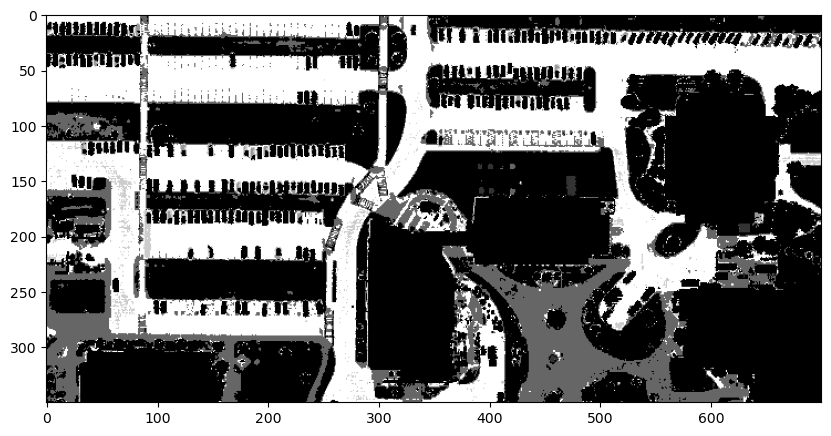

In [28]:
intensity_matrix = np.float32(intensity.reshape(intensity.shape[0] * intensity.shape[1]))
crit = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

val, labels, center = cv.kmeans(intensity_matrix, 6, None, crit, 10, cv.KMEANS_RANDOM_CENTERS)
seg = labels.reshape(intensity.shape)

plt.figure(figsize=(10,10))
plt.imshow(seg * ndsm_mask, cmap='gray')
plt.show()


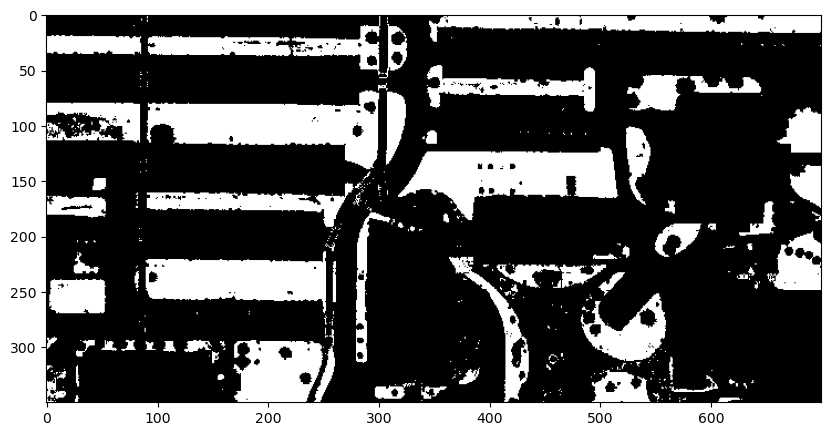

In [36]:

plt.figure(figsize=(10,10))
plt.imshow((seg == 0) * ndsm_mask, cmap='gray')
plt.show() 

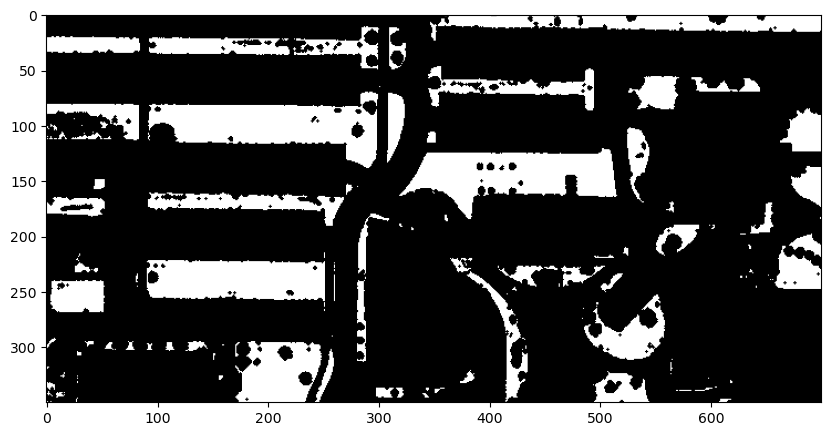

In [37]:
kernel_size = 3
erosion_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
eroded_img = cv.erode(np.uint8(seg==0), erosion_kernel)

plt.figure(figsize=(10,10))
plt.imshow(eroded_img * ndsm_mask, cmap='gray')
plt.show()

number regions: 42


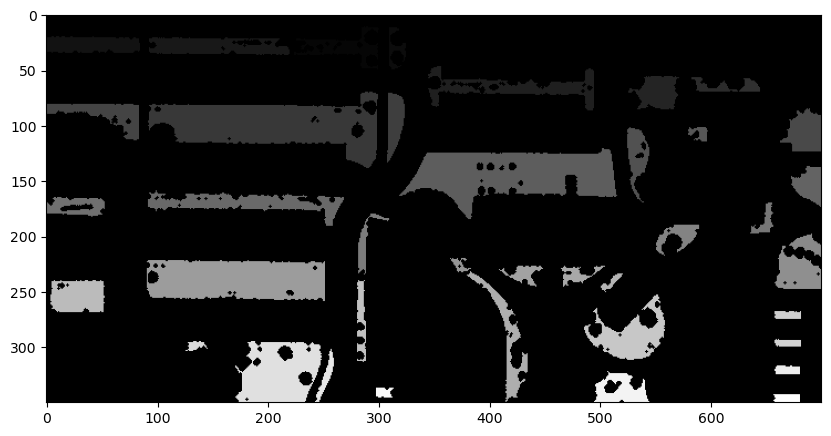

In [43]:

num_features, features, stats, centroids = cv.connectedComponentsWithStats(eroded_img)

size_threshold = 85 # 1 px == 1 sq meters
connected_regions_to_use = {}
current_idx = 0

for ftr_lbl in range(1, num_features):
    if stats[ftr_lbl, 4] >= size_threshold:
        connected_regions_to_use[ftr_lbl] = current_idx
        current_idx += 1

print("number regions:", len(connected_regions_to_use))

used_regions = np.zeros(features.shape)
for r in range(used_regions.shape[0]):
    for c in range(used_regions.shape[1]):
        if features[r,c] in connected_regions_to_use:
            used_regions[r,c] = connected_regions_to_use[features[r,c]]


plt.figure(figsize=(10,10))
plt.imshow(used_regions, cmap='gray')
plt.show()
